In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as se
from sklearn.model_selection import train_test_split
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
print(__doc__)


from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

data = pd.read_csv('training.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

Automatically created module for IPython interactive environment


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [2]:
# checking missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


# **Data Description**

**SeriousDlqin2yrs** Person experienced 90 days past due delinquency or worse

**RevolvingUtilizationOfUnsecuredLines:** Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

**age** Age of borrower in years

**NumberOfTime30-59DaysPastDueNotWorse:** Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

**DebtRatio:** Monthly debt payments, alimony,living costs divided by monthy gross income

**MonthlyIncome:** Monthly income

**NumberOfOpenCreditLinesAndLoans:** Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

**NumberOfTimes90DaysLate:** Number of times borrower has been 90 days or more past due.

**NumberRealEstateLoansOrLines:** Number of mortgage and real estate loans including home equity lines of credit

**NumberOfTime60-89DaysPastDueNotWorse:** Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

**NumberOfDependents:** Number of dependents in family excluding themselves (spouse, children etc.)

**The purpose here is to predict the probability of a person to default. The target attribute is SeriousDlqin2yrs**

The attributes here are discreet values of 0 & 1 as we will see below. Predicting the probability rather than the binary value is due to the fact lenders will need to use the probability to assess and make decision.

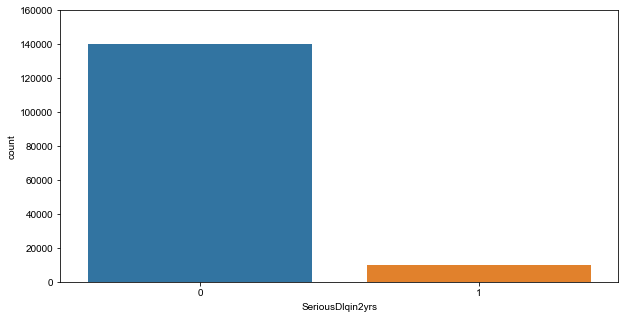

In [3]:
plt.figure(figsize=(10,8))
se.countplot("SeriousDlqin2yrs", data=data)
ax = se.countplot(x = data.SeriousDlqin2yrs)
se.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

plt.show()

In [4]:
#Let's count the number of samples per class

class_0 = data.SeriousDlqin2yrs.value_counts()[0]
class_1 = data.SeriousDlqin2yrs.value_counts()[1]

print('Total Number of Class 0: ', class_0)
print('Total Number of Class 1: ', class_1)

Total Number of Class 0:  139974
Total Number of Class 1:  10026


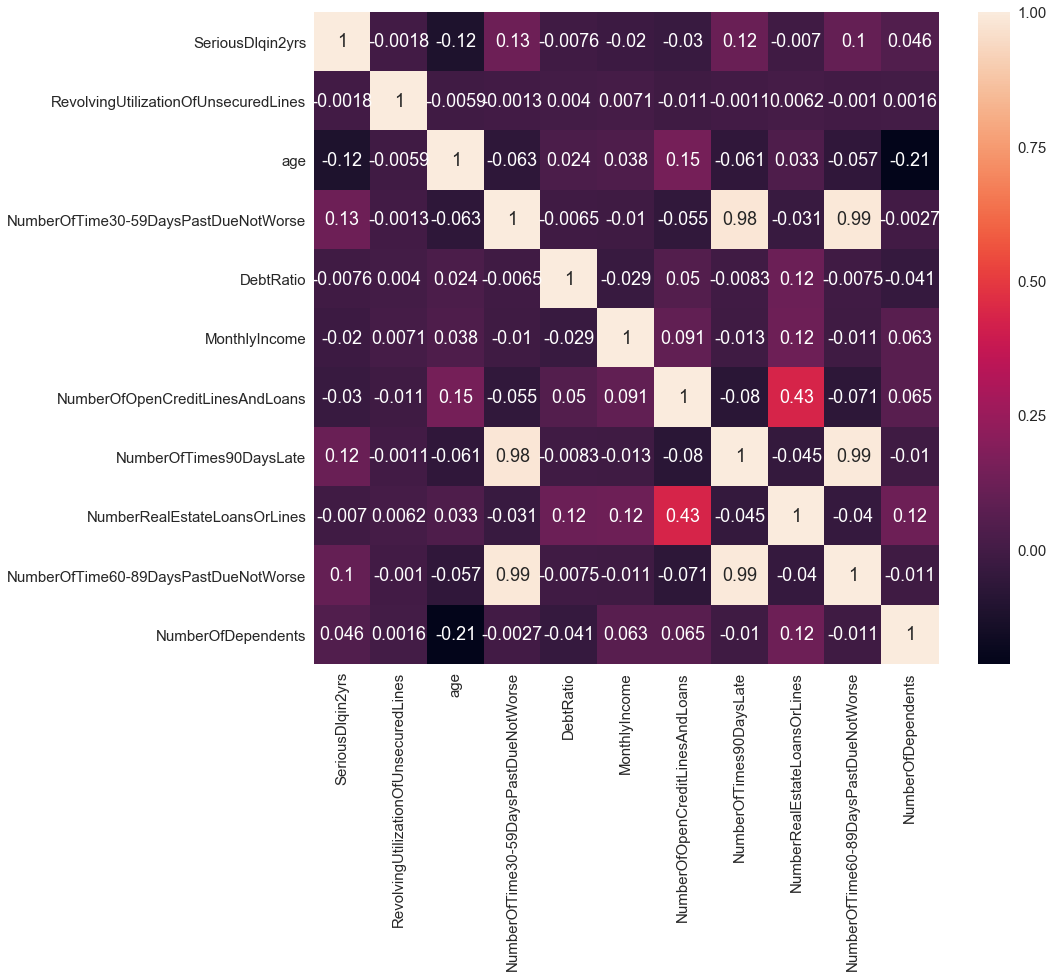

In [5]:
#Test correlation between feautres
#Correlation heatmap
corr = data.corr()
plt.figure(figsize=(14,12))
se.heatmap(corr, annot=True)

**It is noticeable that there is a slight correlation between the ** *SeriousDlqin2yrs* and = *NumberOfTime30-59DaysPastDueNotWorse* AND *NumberOfTimes90DaysLate* AND *NumberOfTime60-89DaysPastDueNotWorse* . 

**This correlation can be troublesome for the algorithm, for now we will proceed with a simple treatment by elemnating the the features and keep only one and we will test the performance of the model on the sample that include all of the feautres and the sample that includes only one feautre.**

**This imbalance in the samples from each class is something that we have to work on. In real life the ratio somwhat similar and in our modeling we need to have the same representation without compromising the performance of the model. In other words our model have to be decently sensitive to each class and precise in the detection.**

**MonthlyIncome** and **NumberOfDependents** have some missing values. Now since we already have an imbalanced dataset, let's see which of the classes contain the more of the missing values from both classes.

In [6]:
misssample = data[['NumberOfDependents', 'MonthlyIncome', 'SeriousDlqin2yrs']]
misssample0 = misssample.loc[misssample['SeriousDlqin2yrs'] == 0]
misssample1 = misssample.loc[misssample['SeriousDlqin2yrs'] == 1]
print('Report counts of missing values from each class')
print('\n Class 0 \n \n Number of missing values for class 0:\n', misssample0.isnull().sum())
print('\n Class 1 \n \n Number of missing values for class 1:\n', misssample1.isnull().sum())

Report counts of missing values from each class

 Class 0 
 
 Number of missing values for class 0:
 NumberOfDependents     3745
MonthlyIncome         28062
SeriousDlqin2yrs          0
dtype: int64

 Class 1 
 
 Number of missing values for class 1:
 NumberOfDependents     179
MonthlyIncome         1669
SeriousDlqin2yrs         0
dtype: int64


In [7]:
# For now let's just fill-in missing values with the mean

data = data.fillna(data.mean())

In [8]:
# Creating two samples one that keep all the features and another one that include only one
# Separating train and test samples by 30 for the testing 
X = data [['RevolvingUtilizationOfUnsecuredLines', 'age',
          'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
          'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
          'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
          'NumberOfDependents']]

X1 = data [['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome',
          'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
          'NumberRealEstateLoansOrLines',
          'NumberOfDependents']]

y = data [['SeriousDlqin2yrs']]

# sample X
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=49)
# sample X1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y,
                                                    test_size=0.30,
                                                    random_state=49)

# Sample X models and performance

### GNB

In [9]:
# Fit to data and predict using pipelined GNB.
GNB_normal = make_pipeline( GaussianNB())
GNB_normal.fit(X_train, y_train)
pred_test_normal = GNB_normal.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB.
clf_GNB_scaled = make_pipeline(StandardScaler(), GaussianNB())
clf_GNB_scaled.fit(X_train, y_train)
pred_test_scaled = clf_GNB_scaled.predict(X_test)

# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf_GNB = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf_GNB.fit(X_train, y_train)
pred_test = unscaled_clf_GNB.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf_GNB = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf_GNB.fit(X_train, y_train)
pred_test_std = std_clf_GNB.predict(X_test)

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset (GNB model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_normal)))

print('\nPrediction accuracy for the standardized test dataset (GNB model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_scaled)))

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA (GNB model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA (GNB model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))


Prediction accuracy for the normal test dataset (GNB model)
93.24%


Prediction accuracy for the standardized test dataset (GNB model)
93.18%


Prediction accuracy for the normal test dataset with PCA (GNB model)
93.32%


Prediction accuracy for the standardized test dataset with PCA (GNB model)
93.24%



### Logistic regression

In [10]:
# Fit to data and predict using pipelined logistic regression.
logreg_normal = make_pipeline(LogisticRegression())
logreg_normal.fit(X_train, y_train)
pred_test_normal = logreg_normal.predict(X_test)


# Fit to data and predict using pipelined scaling, logistic regression.
clf_logreg_scaled = make_pipeline(StandardScaler(), LogisticRegression())
clf_logreg_scaled.fit(X_train, y_train)
pred_test_scaled = clf_logreg_scaled.predict(X_test)


# Fit to data and predict using pipelined logistic regression and PCA.
unscaled_clf_logreg = make_pipeline(PCA(n_components=2), LogisticRegression())
unscaled_clf_logreg.fit(X_train, y_train)
pred_test = unscaled_clf_logreg.predict(X_test)

# Fit to data and predict using pipelined scaling, logistic regression and PCA.
std_clf_logreg = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
std_clf_logreg.fit(X_train, y_train)
pred_test_std = std_clf_logreg.predict(X_test)


# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset (LogisticRegression model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_normal)))

print('\nPrediction accuracy for the standardized test dataset (LogisticRegression model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_scaled)))

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA (LogisticRegression model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA (LogisticRegression model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))


Prediction accuracy for the normal test dataset (LogisticRegression model)
93.44%


Prediction accuracy for the standardized test dataset (LogisticRegression model)
93.44%


Prediction accuracy for the normal test dataset with PCA (LogisticRegression model)
93.32%


Prediction accuracy for the standardized test dataset with PCA (LogisticRegression model)
93.36%



### Random Forest

In [11]:
# Fit to data and predict using pipelined RF.
rf_normal = make_pipeline(RandomForestClassifier(random_state=1234))
rf_normal.fit(X_train, y_train)
pred_test_normal = rf_normal.predict(X_test)


# Fit to data and predict using pipelined scaling, RF.
clf_rf_scaled = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1234))
clf_rf_scaled.fit(X_train, y_train)
pred_test_scaled = clf_rf_scaled.predict(X_test)


# Fit to data and predict using pipelined RF and PCA.
unscaled_clf_rf = make_pipeline(PCA(n_components=2), RandomForestClassifier(random_state=1234))
unscaled_clf_rf.fit(X_train, y_train)
pred_test = unscaled_clf_rf.predict(X_test)

# Fit to data and predict using pipelined scaling, RF and PCA.
std_clf_rf = make_pipeline(StandardScaler(), PCA(n_components=2), RandomForestClassifier(random_state=1234))
std_clf_rf.fit(X_train, y_train)
pred_test_std = std_clf_rf.predict(X_test)


# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset (RF model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_normal)))

print('\nPrediction accuracy for the standardized test dataset (RF model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_scaled)))

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA (RF model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA (RF model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))


Prediction accuracy for the normal test dataset (RF model)
93.23%


Prediction accuracy for the standardized test dataset (RF model)
93.26%


Prediction accuracy for the normal test dataset with PCA (RF model)
92.06%


Prediction accuracy for the standardized test dataset with PCA (RF model)
92.89%



In [12]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## We plot the best model pipeline among the three algorithms

** Prediction accuracy for the normal test dataset (GNB model) 93.24%**

** Prediction accuracy for the normal test dataset (LogisticRegression model) 93.44%**

** Prediction accuracy for the standardized test dataset (RF model) 93.26%**

### Learning Curve

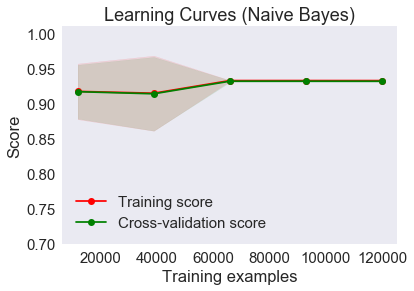

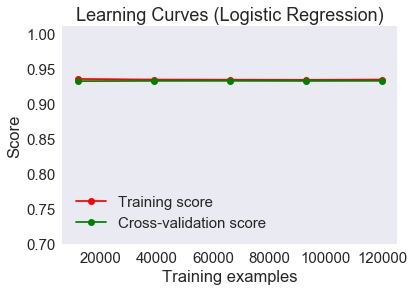

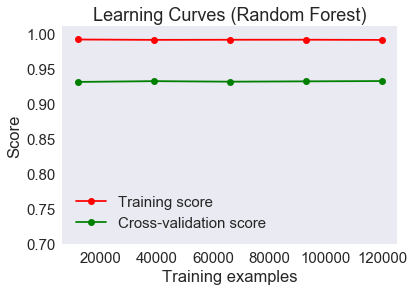

In [13]:
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=49)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

## Calibration Curve for GNB, Logistic Regression, and Random Forest

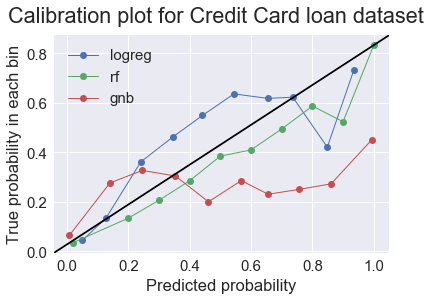

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

GNB_normal = make_pipeline( GaussianNB())
GNB_normal.fit(X_train, y_train)
GNB_prediction = GNB_normal.predict_proba(X_test)


logreg_normal = make_pipeline(LogisticRegression())
logreg_normal.fit(X_train, y_train)
logreg_prediction = logreg_normal.predict_proba(X_test)


clf_rf_scaled = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1234))
clf_rf_scaled.fit(X_train, y_train)
rf_prediction = clf_rf_scaled.predict_proba(X_test)


gnb_y, gnb_x = calibration_curve(y_test, GNB_prediction[:,1], n_bins=10)

logreg_y, logreg_x = calibration_curve(y_test, logreg_prediction[:,1], n_bins=10)

rf_y, rf_x = calibration_curve(y_test, rf_prediction[:,1], n_bins=10)



# calibration curves
fig, ax = plt.subplots()
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')
plt.plot(gnb_x, gnb_y, marker='o', linewidth=1, label='gnb')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Credit Card loan dataset')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

###### This is desappointing and it doesn't look like any shit I want to deploy. Let's try with Sample X1.

# Sample X1

### GNB X1

In [15]:
# Fit to data and predict using pipelined GNB.
GNB_normal = make_pipeline( GaussianNB())
GNB_normal.fit(X1_train, y1_train)
pred_test_normal = GNB_normal.predict(X1_test)

# Fit to data and predict using pipelined scaling, GNB.
clf_GNB_scaled = make_pipeline(StandardScaler(), GaussianNB())
clf_GNB_scaled.fit(X1_train, y1_train)
pred_test_scaled = clf_GNB_scaled.predict(X1_test)

# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf_GNB = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf_GNB.fit(X1_train, y1_train)
pred_test = unscaled_clf_GNB.predict(X1_test)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf_GNB = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf_GNB.fit(X1_train, y1_train)
pred_test_std = std_clf_GNB.predict(X1_test)

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset (GNB model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_normal)))

print('\nPrediction accuracy for the standardized test dataset (GNB model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_scaled)))

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA (GNB model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA (GNB model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_std)))


Prediction accuracy for the normal test dataset (GNB model)
92.92%


Prediction accuracy for the standardized test dataset (GNB model)
92.68%


Prediction accuracy for the normal test dataset with PCA (GNB model)
93.32%


Prediction accuracy for the standardized test dataset with PCA (GNB model)
93.06%



### Logistic Regression X1

In [16]:
# Fit to data and predict using pipelined logistic regression.
logreg_normal = make_pipeline(LogisticRegression())
logreg_normal.fit(X1_train, y1_train)
pred_test_normal = logreg_normal.predict(X1_test)


# Fit to data and predict using pipelined scaling, logistic regression.
clf_logreg_scaled = make_pipeline(StandardScaler(), LogisticRegression())
clf_logreg_scaled.fit(X1_train, y1_train)
pred_test_scaled = clf_logreg_scaled.predict(X1_test)


# Fit to data and predict using pipelined logistic regression and PCA.
unscaled_clf_logreg = make_pipeline(PCA(n_components=2), LogisticRegression())
unscaled_clf_logreg.fit(X1_train, y1_train)
pred_test = unscaled_clf_logreg.predict(X1_test)

# Fit to data and predict using pipelined scaling, logistic regression and PCA.
std_clf_logreg = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
std_clf_logreg.fit(X1_train, y1_train)
pred_test_std = std_clf_logreg.predict(X1_test)


# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset (LogisticRegression model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_normal)))

print('\nPrediction accuracy for the standardized test dataset (LogisticRegression model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_scaled)))

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA (LogisticRegression model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA (LogisticRegression model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_std)))


Prediction accuracy for the normal test dataset (LogisticRegression model)
93.34%


Prediction accuracy for the standardized test dataset (LogisticRegression model)
93.36%


Prediction accuracy for the normal test dataset with PCA (LogisticRegression model)
93.32%


Prediction accuracy for the standardized test dataset with PCA (LogisticRegression model)
93.31%



### Random Forest X1

In [17]:
# Fit to data and predict using pipelined RF.
rf_normal = make_pipeline(RandomForestClassifier(random_state=1234))
rf_normal.fit(X1_train, y1_train)
pred_test_normal = rf_normal.predict(X1_test)


# Fit to data and predict using pipelined scaling, RF.
clf_rf_scaled = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1234))
clf_rf_scaled.fit(X1_train, y1_train)
pred_test_scaled = clf_rf_scaled.predict(X1_test)


# Fit to data and predict using pipelined RF and PCA.
unscaled_clf_rf = make_pipeline(PCA(n_components=2), RandomForestClassifier(random_state=1234))
unscaled_clf_rf.fit(X1_train, y1_train)
pred_test = unscaled_clf_rf.predict(X1_test)

# Fit to data and predict using pipelined scaling, RF and PCA.
std_clf_rf = make_pipeline(StandardScaler(), PCA(n_components=2), RandomForestClassifier(random_state=1234))
std_clf_rf.fit(X1_train, y1_train)
pred_test_std = std_clf_rf.predict(X1_test)


# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset (RF model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_normal)))

print('\nPrediction accuracy for the standardized test dataset (RF model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_scaled)))

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA (RF model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA (RF model)')
print('{:.2%}\n'.format(metrics.accuracy_score(y1_test, pred_test_std)))


Prediction accuracy for the normal test dataset (RF model)
93.21%


Prediction accuracy for the standardized test dataset (RF model)
93.20%


Prediction accuracy for the normal test dataset with PCA (RF model)
92.09%


Prediction accuracy for the standardized test dataset with PCA (RF model)
92.58%



### Learning Curve X1

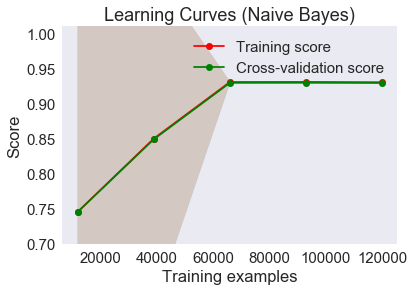

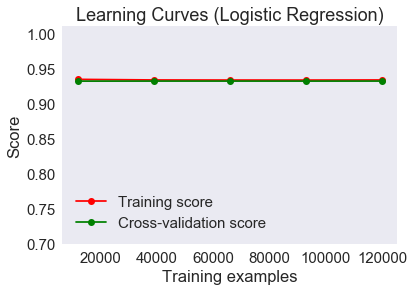

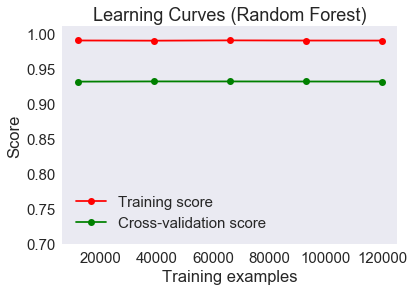

In [18]:
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=49)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X1, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X1, y, (0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X1, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

## X1 Calibration Curve for GNB, Logistic Regression, and Random Forest

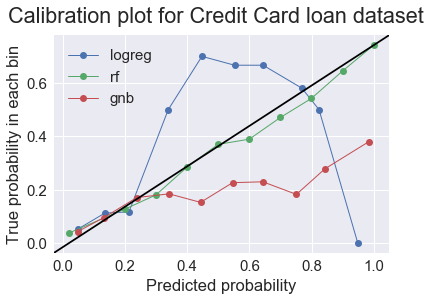

In [19]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

GNB_normal = make_pipeline( GaussianNB())
GNB_normal.fit(X1_train, y1_train)
GNB_prediction = GNB_normal.predict_proba(X1_test)


logreg_normal = make_pipeline(LogisticRegression())
logreg_normal.fit(X1_train, y1_train)
logreg_prediction = logreg_normal.predict_proba(X1_test)


clf_rf_scaled = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1234))
clf_rf_scaled.fit(X1_train, y1_train)
rf_prediction = clf_rf_scaled.predict_proba(X1_test)


gnb_y, gnb_x = calibration_curve(y1_test, GNB_prediction[:,1], n_bins=10)

logreg_y, logreg_x = calibration_curve(y1_test, logreg_prediction[:,1], n_bins=10)

rf_y, rf_x = calibration_curve(y1_test, rf_prediction[:,1], n_bins=10)



# calibration curves
fig, ax = plt.subplots()
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')
plt.plot(gnb_x, gnb_y, marker='o', linewidth=1, label='gnb')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Credit Card loan dataset')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

#### Since the performance of the Random Forest model based on the Learning and Clibration curve seems to be the most consistent, for this limited demo we will go with creating a persistent model for the Random Forest.

In [21]:
from sklearn.externals import joblib

# Save the model
model_filename = 'credit-rf-v1.0.pkl'
print("Saving model to {}...".format(model_filename))
joblib.dump(clf_rf_scaled, model_filename)

Saving model to credit-rf-v1.0.pkl...


['credit-rf-v1.0.pkl']

In [26]:
clf_rf_scaled

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False))])

In [31]:
X1.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfDependents
0,0.766127,45,0.802982,9120.0,13,0,6,2.0
1,0.957151,40,0.121876,2600.0,4,0,0,1.0
2,0.658180,38,0.085113,3042.0,2,1,0,0.0
3,0.233810,30,0.036050,3300.0,5,0,0,0.0
4,0.907239,49,0.024926,63588.0,7,0,1,0.0


In [ ]:
RevolvingUtilizationOfUnsecuredLines=0.766127&age=45&DebtRatio=0.802982&MonthlyIncome=9120.0&NumberOfOpenCreditLinesAndLoans=13&NumberOfTimes90DaysLate=0&NumberRealEstateLoansOrLines=0&NumberOfDependents=2.0

RevolvingUtilizationOfUnsecuredLines=0.957151&age=40&DebtRatio=0.121876&MonthlyIncome=2600.0&NumberOfOpenCreditLinesAndLoans=4&NumberOfTimes90DaysLate=0&NumberRealEstateLoansOrLines=0&NumberOfDependents=1.0

# Request call to the API

In [32]:
import requests
response = requests.get('http://127.0.0.1:5000/predict?RevolvingUtilizationOfUnsecuredLines=0.766127&age=45&DebtRatio=0.802982&MonthlyIncome=9120.0&NumberOfOpenCreditLinesAndLoans=13&NumberOfTimes90DaysLate=0&NumberRealEstateLoansOrLines=0&NumberOfDependents=2.0')
print(response.text)

{
  "label": "default", 
  "status": "complete"
}

